In [1]:
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected, train_test_split_edges
from sklearn.preprocessing import LabelEncoder

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear
from torch import Tensor
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from collections import Counter

In [26]:
# validartion
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, matthews_corrcoef

In [3]:
# set seed
torch.manual_seed(42)
np.random.seed(42)
warnings.filterwarnings('ignore')

In [4]:
def pre_processing(df_graph, 
                   df_features, 
                   col_features,
                   col_target='severity'):
    # create node
    df_features['node'] = np.arange(0, df_features.shape[0])

    # select graph with same node features
    nodes_of_features = list(df_features.leg_pos.unique())
    df_graph_subsample = df_graph.query(" pos1 in @nodes_of_features and pos2 in @nodes_of_features ")
    
    # sync nodes
    df_graph_subsample['src'] = pd.NA
    df_graph_subsample['dst'] = pd.NA
    for i in tqdm(range(df_features.shape[0])):
        node_emb, node = df_features[['leg_pos', 'node']].values[i]
        df_graph_subsample['src'][df_graph_subsample.query(f" pos1 == '{node_emb}' ").index] = node
        df_graph_subsample['dst'][df_graph_subsample.query(f" pos2 == '{node_emb}' ").index] = node

    print(df_graph_subsample.info())
    # subsample graph
    df_graph_subsample = df_graph_subsample.astype({'src': int, 'dst': int})
    # 
    # define x features and target
    #col_features = ['relSESA','consurf_old']
    # 
    pos = df_features.leg_pos.values
    x = torch.tensor(df_features[col_features].values,  dtype=torch.float)
    #y = torch.tensor(df_features[col_target].values, dtype=torch.long)
    # index of graph
    _edge_index = torch.tensor(df_graph_subsample[['src', 'dst']].values, dtype=torch.long)
    
    # encoder target
    encoder = LabelEncoder()
    df_graph_subsample[col_target] = encoder.fit_transform(df_graph_subsample[col_target].values).astype(float)
    
    edge_labels = torch.tensor(df_graph_subsample[col_target].values, dtype=torch.long)
    # weigths edges
    edge_w = torch.tensor(df_graph_subsample['weight'].values, dtype=torch.float)

    return x, edge_labels, _edge_index, edge_w, pos

In [5]:
df_v = pd.read_parquet('df_features.parquet')
df_e = pd.read_parquet('df_edges.parquet')

df_v = df_v.drop(['vm', 'target'], axis=1)
df_v = df_v.rename({'ponto': 'leg_pos'}, axis=1)
df_v = df_v.astype({'leg_pos': str})
df_e = df_e.drop(['vm_edge'], axis=1)
df_v.head()

,leg_pos,carregamento,desce,linha,sobe,trip_id,veiculo
0,100009577,0.946667,0.026667,1.080000,0.480000,1.106667,1.093333
1,100722777,22.069444,5.222222,1.666667,4.840278,1.750000,1.750000
2,100722778,21.402516,1.666667,1.773585,0.081761,2.056604,2.056604
3,101214305,7.982759,4.465517,1.000000,0.620690,1.000000,1.000000
4,101269104,77.882653,16.591837,4.540816,10.285714,5.520408,5.520408


In [6]:
f_selected = ['carregamento', 'desce', 'linha', 'sobe', 'trip_id', 'veiculo']

In [7]:
df_e.head()
df_e = df_e.rename({'src': 'pos1', 'dst': 'pos2', 'loader': 'weight'}, axis=1)
df_e = df_e.astype({'pos1': str, 'pos2': str})
df_e.head()

,pos1,pos2,weight,target
0,100009577,345936831,1.136364,normal
1,100722777,100722778,11.437086,devagar
2,100722777,44782645,2.425000,devagar
3,100722777,45833440,14.268293,devagar
4,100722777,66771046,14.948718,devagar


In [8]:
xa, edge_labelsa, edge_indexa, edge_wa, posa =  pre_processing(df_e, 
                                                              df_v, 
                                                              f_selected,
                                                              col_target='target')

100% 2833/2833 [00:10<00:00, 275.71it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4522 entries, 0 to 4523
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pos1    4522 non-null   object 
 1   pos2    4522 non-null   object 
 2   weight  4522 non-null   float64
 3   target  4522 non-null   object 
 4   src     4522 non-null   object 
 5   dst     4522 non-null   object 
dtypes: float64(1), object(5)
memory usage: 376.3+ KB
None


In [9]:
# Ensure the graph is undirected
#edge_index = to_undirected(edge_indexa)

In [10]:
edge_labelsa.shape, edge_indexa.shape

(torch.Size([4522]), torch.Size([4522, 2]))

In [11]:
edge_labelsa.shape

torch.Size([4522])

In [12]:
edge_labels_oh = torch.nn.functional.one_hot(edge_labelsa)
edge_labels_oh.shape

torch.Size([4522, 4])

In [13]:
edge_labels_oh = edge_labels_oh.float()
edge_labels_oh

tensor([[0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        ...,
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.]])

In [14]:
data = Data(x=xa, 
            edge_index=edge_indexa.t().contiguous())

In [15]:
data

Data(x=[2833, 6], edge_index=[2, 4522])

In [16]:
# Split edges into train and test sets
data = train_test_split_edges(data, val_ratio=0.0, test_ratio=0.2)

In [17]:
data

Data(x=[2833, 6], val_pos_edge_index=[2, 0], test_pos_edge_index=[2, 471], train_pos_edge_index=[2, 3770], train_neg_adj_mask=[2833, 2833], val_neg_edge_index=[2, 0], test_neg_edge_index=[2, 471])

In [18]:
type(data.x)

torch.Tensor

In [19]:
# Extract train and test edge indices and labels
train_edge_index = data.train_pos_edge_index
test_edge_index = data.test_pos_edge_index

# For simplicity, use the same labels for train and test (replace with actual labels if available)
train_edge_labels = edge_labels_oh[:train_edge_index.size(1)]
test_edge_labels = edge_labels_oh[:test_edge_index.size(1)]

In [20]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        #x, edge_index = data.x, data.edge_index
        #print(f"")
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [21]:
def get_edge_features(node_embeddings, edge_index):
    src, tgt = edge_index
    edge_features = torch.cat((node_embeddings[src], node_embeddings[tgt]), dim=1)
    return edge_features

In [22]:
class EdgeClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(EdgeClassifier, self).__init__()
        self.fc1 = torch.nn.Linear(in_channels, hidden_channels)
        self.fc2 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, edge_features):
        x = F.relu(self.fc1(edge_features))
        x = self.fc2(x)
        return x

In [23]:
# Hyperparameters
in_channels = data.x.shape[1]
hidden_channels = 16
node_embedding_dim = 16
edge_hidden_dim = 8
num_edge_classes = edge_labels_oh.shape[1]  # Example: binary classification

# Initialize models
gcn = GCN(in_channels, hidden_channels, node_embedding_dim)
edge_classifier = EdgeClassifier(2 * node_embedding_dim, edge_hidden_dim, num_edge_classes)

# Optimizer
optimizer = torch.optim.Adam(list(gcn.parameters()) + list(edge_classifier.parameters()), lr=0.01)

In [24]:
# Training loop
scores = []
for epoch in tqdm(range(500)):  # Number of epochs
    
    gcn.train()
    edge_classifier.train()
    optimizer.zero_grad()

    # Forward pass through GCN to get node embeddings
    node_embeddings = gcn(data.x, train_edge_index)

    # Get edge features from node embeddings for training edges
    train_edge_features = get_edge_features(node_embeddings, train_edge_index)

    # Classify training edges
    train_edge_predictions = edge_classifier(train_edge_features)
    
    # Compute loss
    loss = F.cross_entropy(train_edge_predictions, train_edge_labels)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    scores.append(loss.item())

    #print(f'Epoch {epoch+1}, Loss: {loss.item()}')

print(f'Training completed with init loss {scores[0]} and last loss: {scores[-1]}.')

100% 500/500 [00:02<00:00, 180.01it/s]

Training completed with init loss 1.2169629335403442 and last loss: 0.9562596082687378.


## Test

In [27]:
gcn.eval()
edge_classifier.eval()

# Forward pass through GCN to get node embeddings
node_embeddings = gcn(data.x, test_edge_index)

# Get edge features from node embeddings for test edges
test_edge_features = get_edge_features(node_embeddings, test_edge_index)

# Classify test edges
test_edge_predictions = edge_classifier(test_edge_features)

y_true = test_edge_labels.argmax(dim=1)
y_pred = test_edge_predictions.argmax(dim=1)

# Example evaluation metric: accuracy
correct = (y_pred == y_true).sum()
accuracy = int(correct) / test_edge_labels.size(0)

print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.5329


In [28]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Compute MCC
mcc = matthews_corrcoef(y_true, y_pred)
print("MCC:", mcc)

Confusion Matrix:
[[  0   0   0   8]
 [  0  13   2 163]
 [  0   3   0  30]
 [  0  12   2 238]]
MCC: 0.04154870758612794


In [33]:
Counter(y_true.numpy())

Counter({3: 252, 1: 178, 2: 33, 0: 8})

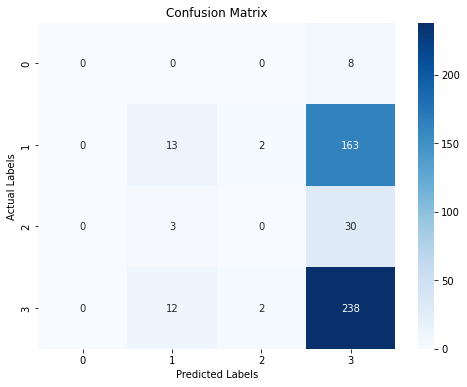

In [34]:
# Create a heatmap plot of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, 
            fmt='d', cmap='Blues', 
            xticklabels=['0', '1', '2', '3'], 
            yticklabels=['0', '1', '2', '3'])
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()